# LSTM Models
This notebook contains code for training and evaluating the LSTM-based models of the project.

## Imports

In [1]:
# General
import numpy as np
from scipy import signal
from tqdm import tqdm
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib import rc
from collections import Counter
from sklearn.metrics import f1_score

# Torch modules
import torch
import torch.autograd as autograd
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Bespoke functions
from src import (
    load_depresjon,
    load_psykose,
    load_joint_dataset,
    convert_to_torch,
    validation_metrics,
    find_longest_sequence,
    reconstruct_data_sequences,
    check_reconstructed_sequences,
    batch_full_sequence,
    balance_train,
    batch_data,
    plot_training_progress,
    train
)

# Settings
sns.set_style("whitegrid")
sns.set_context("paper")
rc("font", family="serif", size=18)
rc("text", usetex=False)
sns.set(rc={"figure.figsize": (11.7, 8.27)})

2023-01-02 18:22:15.901130: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## 1st and 2nd batch of experiments
This 1st part of the module contains the code for our initial experiments with LSTM-based model architectures. All of these are trained on 24 hour subsequences. We define three models:
- `AttentionLSTM`: The original proposed architecture – a bidirectional LSTM model with an attention layer.
- `SimpleLSTM`: A simpler version of `AttentionLSTM` where hidden states are not averaged before they are passed to the dense layers.
- `MultipleLSTMCells`: An LSTM models with multiple independent LSTMCells, corresponding to each time point in the motor activity sequence, each with its own hyperparameters.

For the sake of brevity, we only show an example of training of one of these models since none of the models were performing very well.

### Load the data

In [2]:
df = load_joint_dataset()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
data = convert_to_torch(
    df,
    slice_seq=True,
    preprocessing="smooth",
    k=5,
    train_perc=0.60,
    val_perc=0.20,
    random_seed=42,
    device=device,
)

train_data, val_data, test_data = data

2023-01-02 18:07:05.591 | INFO     | src.load_data:load_depresjon:44 - Loading depresjon
2023-01-02 18:07:09.342 | INFO     | src.load_data:load_psykose:77 - Loading psykose
2023-01-02 18:07:10.802 | INFO     | src.load_data:load_hyperaktiv:110 - Loading hyperaktiv
2023-01-02 18:09:24.820 | INFO     | src.load_data:convert_to_torch:180 - Applying preprocessing and converting to torch
2023-01-02 18:09:24.821 | INFO     | src.load_data:convert_to_torch:184 - Filtering out problematic dates
2023-01-02 18:09:27.081 | INFO     | src.load_data:convert_to_torch:196 - Filtering out data points before the earliest 00:00 and after the latest 23:59 for each subject
2023-01-02 18:09:36.383 | INFO     | src.load_data:convert_to_torch:229 - Splitting dataset in train, validation, and test datasets
2023-01-02 18:09:50.190 | INFO     | src.utils:train_val_test_split_sequences:313 - Split dataset into
   Training set:
      59.33% of total sequences
      Subjects: ADHD: 38, ADHD_Control: 31, DEPR: 19,

### Define the models

In [3]:
class AttentionLSTM(nn.Module):
    def __init__(self, seq_len, LSTM_hidden_size, n_layers, output_size, dropout_prob):
        super(AttentionLSTM, self).__init__()
        self.lstm = nn.LSTM(1, LSTM_hidden_size, n_layers, bidirectional=True)
        self.dense_1 = nn.Linear(seq_len, seq_len)
        self.dense_2 = nn.Linear(seq_len, seq_len // 10)
        self.dropout = nn.Dropout(p=dropout_prob)
        self.dense_3 = nn.Linear(seq_len // 10, output_size)

    def forward(self, x):
        # Send sequence through LSTM and concatenate hidden states
        hidden_states, _ = self.lstm(x)
        hidden_states_cat = hidden_states.mean(axis=1)

        # Send through 1st dense layer
        output_dense_1 = self.dense_1(hidden_states_cat)
        attention_scores = F.softmax(output_dense_1, dim=0)

        # Compute the context vector
        context_vector = attention_scores * hidden_states_cat
        context_vector = torch.tanh(context_vector)

        # Compute prediction
        output_dense_2 = self.dense_2(context_vector)
        output_dense_2 = torch.tanh(output_dense_2)
        output_dense_2 = self.dropout(output_dense_2)
        output_dense_3 = self.dense_3(output_dense_2)
        output_dense_3 = torch.tanh(output_dense_3)

        return output_dense_3


class SimpleLSTM(nn.Module):
    def __init__(
        self,
        seq_len,
        LSTM_hidden_size,
        n_LSTM_layers,
        linear_hidden_size,
        output_size,
        dropout_1_prob,
        dropout_2_prob,
    ):
        super(SimpleLSTM, self).__init__()
        self.lstm = nn.LSTM(1, LSTM_hidden_size, n_LSTM_layers, bidirectional=True)
        self.linear_1 = nn.Linear(seq_len * 2 * LSTM_hidden_size, linear_hidden_size)
        self.linear_2 = nn.Linear(linear_hidden_size, output_size)
        self.dropout_1 = nn.Dropout(dropout_1_prob)
        self.dropout_2 = nn.Dropout(dropout_2_prob)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = x.flatten()
        x = torch.tanh(x)
        x = self.dropout_1(x)
        x = self.linear_1(x)
        x = torch.tanh(x)
        x = self.dropout_2(x)
        x = self.linear_2(x)
        return x


class MultipleLSTMCells(nn.Module):
    def __init__(
        self,
        seq_len,
        LSTM_hidden_size,
        linear_size,
        output_size,
        dropout_prob_1,
        dropout_prob_2,
        device,
    ):
        super(MultipleLSTMCells, self).__init__()
        self.seq_len = seq_len
        self.device = device
        self.LSTM_hidden_size = LSTM_hidden_size
        self.LSTM_cells_forward = nn.ModuleList(
            [nn.LSTMCell(1, LSTM_hidden_size) for _ in range(seq_len)]
        )
        self.LSTM_cells_backward = nn.ModuleList(
            [nn.LSTMCell(1, LSTM_hidden_size) for _ in range(seq_len)]
        )
        self.dropout_1 = nn.Dropout(dropout_prob_1)
        self.linear_1 = nn.Linear(seq_len * LSTM_hidden_size * 2, 500)
        self.dropout_2 = nn.Dropout(dropout_prob_2)
        self.linear_2 = nn.Linear(linear_size, output_size)

    def forward(self, x):
        # Perform forward pass
        hx, cx = 2 * [torch.zeros(self.LSTM_hidden_size).to(self.device)]
        hidden_outputs_forward = torch.empty((self.seq_len, self.LSTM_hidden_size)).to(self.device)
        for time_step in range(len(x)):
            hx, cx = self.LSTM_cells_forward[time_step](x[time_step], (hx, cx))
            hidden_outputs_forward[time_step] = hx

        # Perform backward pass
        hx, cx = 2 * [torch.zeros(self.LSTM_hidden_size).to(self.device)]
        hidden_outputs_backward = torch.empty((self.seq_len, self.LSTM_hidden_size)).to(self.device)
        for time_step in range(len(x) - 1, -1, -1):
            hx, cx = self.LSTM_cells_forward[time_step](x[time_step], (hx, cx))
            hidden_outputs_backward[time_step] = hx

        # Pass through linear layers
        x = torch.cat(
            [hidden_outputs_forward, hidden_outputs_backward], dim=1
        ).flatten()
        x = torch.tanh(x)
        x = self.dropout_1(x)
        x = self.linear_1(x)
        x = torch.tanh(x)
        x = self.dropout_2(x)
        x = self.linear_2(x)
        return x

### Initialise the model

In [4]:
# Define model parameters
seq_len = len(train_data[0][0])
output_dim = len(train_data[0][1])
LSTM_hidden_size = 20
n_LSTM_layers = 2
linear_hidden_size = 32
dropout_prob_1 = 0.1
dropout_prob_2 = 0.1

# Initialize the model
model = SimpleLSTM(
    seq_len,
    LSTM_hidden_size,
    n_LSTM_layers,
    linear_hidden_size,
    output_dim,
    dropout_prob_1,
    dropout_prob_2,
)
model.to(device)
model(train_data[0][0])

tensor([-0.1402,  0.0414, -0.0419,  0.0042], grad_fn=<AddBackward0>)

### Train the model

tensor([6.7696, 2.0721, 5.7982, 5.0706])


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 loss: 0.91209


  5%|▌         | 1/20 [00:20<06:24, 20.22s/it]

Epoch: 2 loss: 0.87382


 10%|█         | 2/20 [00:40<06:02, 20.14s/it]

Epoch: 3 loss: 0.86705


 15%|█▌        | 3/20 [01:00<05:46, 20.39s/it]

Epoch: 4 loss: 0.86033


 20%|██        | 4/20 [01:20<05:23, 20.23s/it]

Epoch: 5 loss: 0.85547


 25%|██▌       | 5/20 [01:40<05:01, 20.11s/it]

Epoch: 6 loss: 0.85292


 30%|███       | 6/20 [02:00<04:40, 20.01s/it]

Epoch: 7 loss: 0.84780


 35%|███▌      | 7/20 [02:20<04:19, 20.00s/it]

Epoch: 8 loss: 0.84622


 40%|████      | 8/20 [02:40<03:59, 19.97s/it]

Epoch: 9 loss: 0.84485


 45%|████▌     | 9/20 [03:00<03:39, 19.92s/it]

Epoch: 10 loss: 0.84460


 50%|█████     | 10/20 [03:20<03:21, 20.11s/it]

Epoch: 11 loss: 0.84239


 55%|█████▌    | 11/20 [03:40<03:00, 20.09s/it]

Epoch: 12 loss: 0.84107


 60%|██████    | 12/20 [04:00<02:40, 20.07s/it]

Epoch: 13 loss: 0.83708


 65%|██████▌   | 13/20 [04:21<02:20, 20.05s/it]

Epoch: 14 loss: 0.83687


 70%|███████   | 14/20 [04:40<02:00, 20.01s/it]

Epoch: 15 loss: 0.83437


 75%|███████▌  | 15/20 [05:00<01:39, 19.99s/it]

Epoch: 16 loss: 0.83501


 80%|████████  | 16/20 [05:20<01:19, 19.98s/it]

Epoch: 17 loss: 0.83225


 85%|████████▌ | 17/20 [05:40<00:59, 19.95s/it]

Epoch: 18 loss: 0.83248


 90%|█████████ | 18/20 [06:01<00:40, 20.12s/it]

Epoch: 19 loss: 0.82957


 95%|█████████▌| 19/20 [06:21<00:20, 20.05s/it]

Epoch: 20 loss: 0.82761


100%|██████████| 20/20 [06:40<00:00, 20.05s/it]


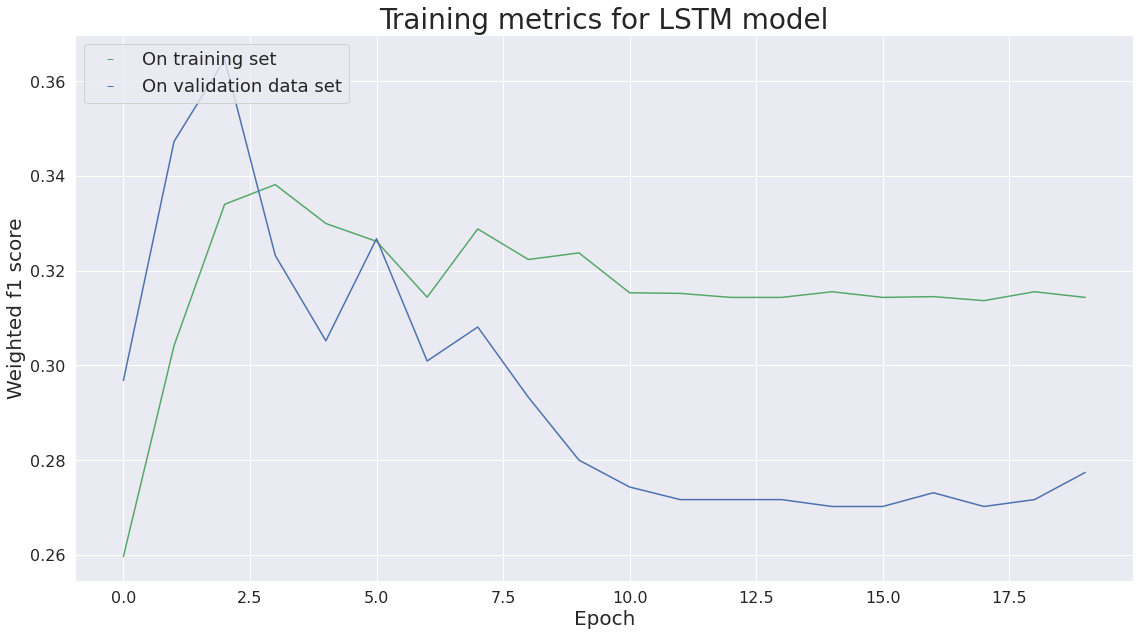

In [ ]:
# Define training parameters
learning_rate = 0.001
epochs = 20

# Train model
model, train_f1s, val_f1s = train(
    model,
    train_data,
    val_data,
    learning_rate=learning_rate,
    epochs=epochs,
    device=device
)

# Plot training progress
plot_training_progress(train_f1s, val_f1s)

## BiLSTM with attention using full sequences but split training
This part of the notebook contains the BiLSTM with attention implementation but trains the model on segments of the train dataset in a bid to provide empirical evidence that increases in the train data leads to an increase in the model's performance. The train data used here consists of full length sequences that have not been averaged. These sequences were just batched and then passed through an LSTM encoder to generate 1440 (24 hour) data sequences which were then used in the remainder of the network.

### Load the data

In [ ]:
df = load_joint_dataset()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
data = convert_to_torch(
    df,
    slice_seq=False,
    preprocessing="False",
    k=10,
    train_perc=0.60,
    val_perc=0.20,
    random_seed=42,
    device=device,
)

train_data, val_data, test_data = data


     |█████▋                          | 10 kB 22.3 MB/s eta 0:00:01
     |███████████▎                    | 20 kB 27.0 MB/s eta 0:00:01
     |████████████████▉               | 30 kB 9.4 MB/s eta 0:00:01
     |██████████████████████▌         | 40 kB 4.6 MB/s eta 0:00:01
     |████████████████████████████    | 51 kB 5.3 MB/s eta 0:00:01
     |████████████████████████████████| 58 kB 2.9 MB/s 


2023-01-02 12:29:18.198 | INFO     | load_data:load_depresjon:36 - Loading depresjon
2023-01-02 12:29:23.765 | INFO     | load_data:load_psykose:54 - Loading psykose
2023-01-02 12:29:26.373 | INFO     | load_data:load_hyperaktiv:72 - Loading hyperaktiv
2023-01-02 12:30:49.077 | INFO     | load_data:convert_to_torch:222 - Converting to torch
2023-01-02 12:30:49.079 | INFO     | load_data:convert_to_torch:225 - Filtering out problematic dates
2023-01-02 12:31:13.306 | INFO     | load_data:train_val_test_split:188 - Split dataset into
   Training set:
      59.49% of total sequences
      Subjects: ADHD: 36, ADHD_Control: 36, DEPR_Control: 27, SZ: 16, DEPR: 18
   Validation set:
      20.20% of total sequences
      Subjects: ADHD: 9, ADHD_Control: 4, DEPR_Control: 5, DEPR: 5, SZ: 6
   Test set:
      20.31% of total sequences
      Subjects: DEPR_Control: 7, ADHD: 7, ADHD_Control: 6, SZ: 5, DEPR: 4



### Breakup of the data for experiments


In [ ]:
# Break-up of the train data
half_train = train_data[:len(train_data)//2]
quarter_train = train_data[:len(train_data)//4]
sixth_train = train_data[:len(train_data)//6]

print(len(quarter_train))

26


### Balance the train dataset

In [ ]:
balanced_train_data = balance_train(train_data)

### Ascertain the number of data points in the longest present sequence

In [ ]:
longest_length = find_longest_sequence([quarter_train, test_data, val_data])
longest_length

48960

### Reconstruct the data sequences to ensure that they all have the same length


In [ ]:
reconstructed_train, reconstructed_val, reconstructed_test = reconstruct_data_sequences(
    [quarter_train, test_data, val_data], 48960
)
print(len(reconstructed_train))

26


In [ ]:
check_reconstructed_sequences(reconstructed_train, 48960)

True

### Define the BiLSTM with Attention Network

In [ ]:
class BiLSTMAttentionNetwork(nn.Module):
    def __init__(
        self,
        total_input_seq_len,
        encoder_output_len,
        seq_len,
        LSTM_input_len,
        LSTM_hidden_size,
        n_layers,
        output_size,
        dropout=0.0,
    ):
        super(BiLSTMAttentionNetwork, self).__init__()
        self.encoder = nn.LSTM(
            total_input_seq_len, encoder_output_len // 2, n_layers, bidirectional=True
        )
        self.lstm = nn.LSTM(
            encoder_output_len, LSTM_hidden_size, n_layers, bidirectional=True
        )
        self.dense_1 = nn.Linear(LSTM_hidden_size * 2, LSTM_hidden_size * 2)
        self.dense_2 = nn.Linear(LSTM_hidden_size * 2, seq_len)
        self.dense_3 = nn.Linear(seq_len, seq_len // 2)
        self.dropout = nn.Dropout(p=dropout)
        self.dense_4 = nn.Linear(seq_len // 2, output_size)

    def forward(self, x):
        # batch the data sequence
        batched_input = batch_full_sequence(x)

        # Encode the data sequence
        # encoded_input_sequence, _ = self.encoder(torch.transpose(x,0,1))
        encoded_input_sequence, _ = self.encoder(batched_input)

        # Flatten the encoded input sequence
        flattened_encoded_input = encoded_input_sequence.flatten()

        # Batch the generated encoded input sequence
        batched_seq = batch_data(encoded_input_sequence)

        # Send through LSTM and concatenate hidden states
        hidden_states, _ = self.lstm(batched_seq)
        hidden_states_cat = hidden_states.mean(axis=0)

        # Send through 1st dense layer
        output_dense_1 = self.dense_1(hidden_states_cat)
        attention_scores = F.softmax(output_dense_1, dim=0)

        # Compute the context vector
        context_vector = attention_scores * hidden_states_cat
        context_vector = torch.tanh(context_vector)

        # Compute prediction
        output_dense_2 = self.dense_2(context_vector)
        output_dense_2 = torch.tanh(output_dense_2)
        output_dense_3 = self.dense_3(output_dense_2)
        output_dense_3 = torch.tanh(output_dense_3)
        output_dense_3 = self.dropout(output_dense_3)
        output_dense_4 = self.dense_4(output_dense_3)

        return output_dense_4

### Initialise the BiLSTM Attention Network

In [ ]:
# Define model parameters
LSTM_hidden_size = 150
n_layers = 1
dropout = 0.1
seq_len = 50
LSTM_input_len = 12240
output_size = 4
total_input_seq_len = longest_length // 4
encoder_output_len = 360

# Initialize the model
model = BiLSTMAttentionNetwork(
    total_input_seq_len,
    encoder_output_len,
    seq_len,
    LSTM_input_len,
    LSTM_hidden_size,
    n_layers,
    output_size,
    dropout=0.0,
)
model.to(device)

BiLSTMAttentionNetwork(
  (encoder): LSTM(12240, 180, bidirectional=True)
  (lstm): LSTM(360, 150, bidirectional=True)
  (dense_1): Linear(in_features=300, out_features=300, bias=True)
  (dense_2): Linear(in_features=300, out_features=50, bias=True)
  (dense_3): Linear(in_features=50, out_features=25, bias=True)
  (dropout): Dropout(p=0.0, inplace=False)
  (dense_4): Linear(in_features=25, out_features=4, bias=True)
)

Training the model


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 loss: 0.00896
actual class values:  [0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 3, 0, 1, 3, 0, 2, 1, 0, 2, 1, 1, 3, 1, 2, 1, 3, 1, 2, 3, 0, 1, 2, 1, 0, 2, 0, 2, 3, 1, 2, 1, 1, 1, 0, 1, 1, 2, 1, 3, 1, 1]
predicted class values:  [0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 3, 0, 1, 3, 0, 3, 1, 0, 3, 1, 1, 3, 1, 3, 1, 3, 1, 3, 3, 0, 1, 3, 1, 0, 3, 0, 3, 3, 1, 3, 1, 1, 1, 0, 1, 1, 3, 1, 3, 1, 1]
actual class values:  [1, 2, 0, 3, 3, 1, 2, 1, 1, 3, 2, 1, 1, 1, 2, 1, 1, 1, 1, 3, 2, 1, 0, 3, 1, 0, 1, 1, 1]



 20%|██        | 1/5 [00:03<00:12,  3.15s/it]

predicted class values:  [0, 1, 0, 1, 1, 3, 1, 0, 1, 1, 0, 3, 0, 3, 3, 1, 1, 3, 1, 3, 0, 3, 3, 3, 3, 0, 3, 3, 3]
Epoch: 2 loss: 0.00719
actual class values:  [0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 3, 0, 1, 3, 0, 2, 1, 0, 2, 1, 1, 3, 1, 2, 1, 3, 1, 2, 3, 0, 1, 2, 1, 0, 2, 0, 2, 3, 1, 2, 1, 1, 1, 0, 1, 1, 2, 1, 3, 1, 1]
predicted class values:  [0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 2, 0, 2, 1, 0, 2, 1, 1, 2, 1, 2, 1, 2, 1, 2, 2, 0, 1, 2, 1, 0, 2, 0, 2, 2, 1, 2, 1, 1, 1, 0, 1, 1, 2, 1, 2, 1, 1]
actual class values:  [1, 2, 0, 3, 3, 1, 2, 1, 1, 3, 2, 1, 1, 1, 2, 1, 1, 1, 1, 3, 2, 1, 0, 3, 1, 0, 1, 1, 1]



 40%|████      | 2/5 [00:06<00:09,  3.10s/it]

predicted class values:  [0, 1, 0, 1, 1, 2, 1, 0, 1, 1, 0, 2, 0, 2, 2, 1, 1, 0, 1, 2, 0, 0, 2, 2, 2, 0, 2, 2, 2]
Epoch: 3 loss: 0.00645
actual class values:  [0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 3, 0, 1, 3, 0, 2, 1, 0, 2, 1, 1, 3, 1, 2, 1, 3, 1, 2, 3, 0, 1, 2, 1, 0, 2, 0, 2, 3, 1, 2, 1, 1, 1, 0, 1, 1, 2, 1, 3, 1, 1]
predicted class values:  [0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 2, 0, 2, 1, 0, 2, 1, 1, 2, 1, 2, 1, 2, 1, 2, 2, 0, 1, 2, 1, 0, 2, 0, 2, 2, 1, 2, 1, 1, 1, 0, 1, 1, 2, 1, 2, 1, 1]
actual class values:  [1, 2, 0, 3, 3, 1, 2, 1, 1, 3, 2, 1, 1, 1, 2, 1, 1, 1, 1, 3, 2, 1, 0, 3, 1, 0, 1, 1, 1]



 60%|██████    | 3/5 [00:09<00:06,  3.09s/it]

predicted class values:  [0, 1, 0, 1, 1, 2, 1, 0, 1, 1, 0, 2, 0, 2, 2, 1, 1, 0, 1, 2, 0, 0, 2, 2, 2, 0, 2, 2, 2]
Epoch: 4 loss: 0.00610
actual class values:  [0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 3, 0, 1, 3, 0, 2, 1, 0, 2, 1, 1, 3, 1, 2, 1, 3, 1, 2, 3, 0, 1, 2, 1, 0, 2, 0, 2, 3, 1, 2, 1, 1, 1, 0, 1, 1, 2, 1, 3, 1, 1]
predicted class values:  [0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 2, 0, 2, 1, 0, 2, 1, 1, 2, 1, 2, 1, 2, 1, 2, 2, 0, 1, 2, 1, 0, 2, 0, 2, 2, 1, 2, 1, 1, 1, 0, 1, 1, 2, 1, 2, 1, 1]
actual class values:  [1, 2, 0, 3, 3, 1, 2, 1, 1, 3, 2, 1, 1, 1, 2, 1, 1, 1, 1, 3, 2, 1, 0, 3, 1, 0, 1, 1, 1]



 80%|████████  | 4/5 [00:12<00:03,  3.09s/it]

predicted class values:  [0, 1, 0, 1, 1, 2, 1, 0, 1, 1, 0, 2, 0, 2, 2, 1, 1, 0, 1, 1, 0, 0, 2, 2, 2, 0, 1, 2, 2]
Epoch: 5 loss: 0.00576
actual class values:  [0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 3, 0, 1, 3, 0, 2, 1, 0, 2, 1, 1, 3, 1, 2, 1, 3, 1, 2, 3, 0, 1, 2, 1, 0, 2, 0, 2, 3, 1, 2, 1, 1, 1, 0, 1, 1, 2, 1, 3, 1, 1]
predicted class values:  [0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 2, 0, 2, 1, 0, 2, 1, 1, 2, 1, 2, 1, 2, 1, 2, 2, 0, 1, 0, 1, 0, 2, 0, 0, 2, 1, 2, 1, 1, 1, 0, 1, 1, 2, 1, 2, 1, 1]
actual class values:  [1, 2, 0, 3, 3, 1, 2, 1, 1, 3, 2, 1, 1, 1, 2, 1, 1, 1, 1, 3, 2, 1, 0, 3, 1, 0, 1, 1, 1]


100%|██████████| 5/5 [00:15<00:00,  3.09s/it]

predicted class values:  [1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0]


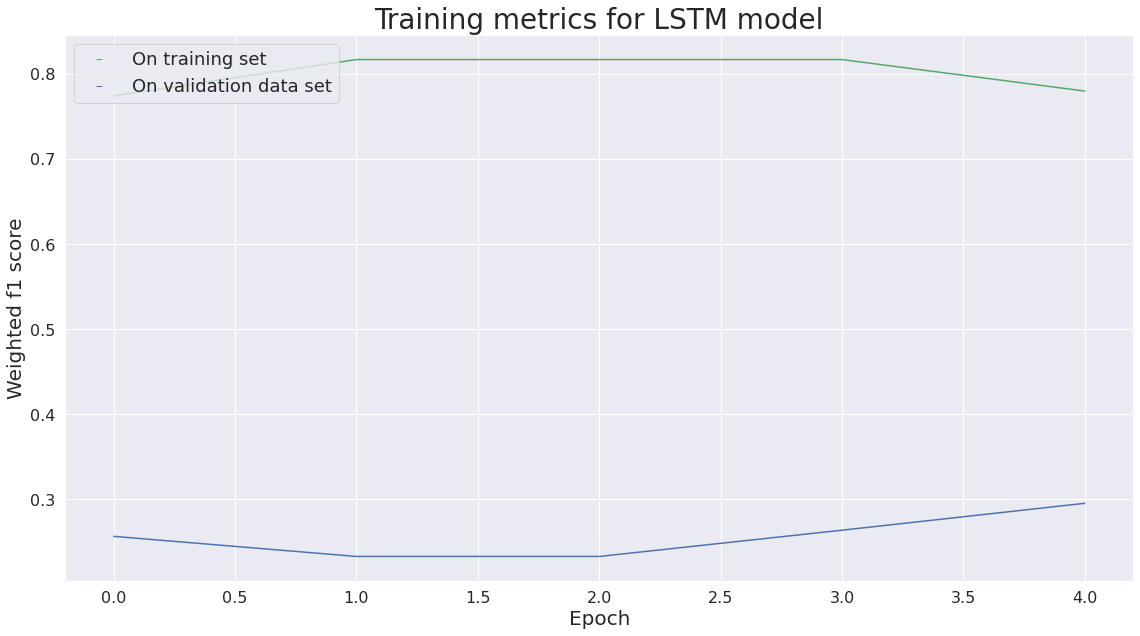

In [ ]:
# Set learning parameters
learning_rate = 0.001
epochs = 5

# Reconstruct motor activity sequences
reconstructed_train, reconstructed_val, reconstructed_test = reconstruct_data_sequences(
    [half_train, test_data, val_data], 48960
)

# Train the model
model, train_f1s, val_f1s = train(
    model,
    reconstructed_train,
    reconstructed_val,
    learning_rate=learning_rate,
    epochs=epochs,
    device=device,
)

# Plot training progress
plot_training_progress(train_f1s, val_f1s)

## BiLSTM with attention implementation for batched 24 hour sequences
This part of the notebook contains the BiLSTM with attention implementation for the complete sequence split data. In this implementation, each sequence is fed into a Linear Layer to encode it into a 1440 length sequence which is then passed through the BiLSTM layer to obtain the hidden vectors which are used in the remainder of the network.

### Load the data

In [ ]:
df = load_joint_dataset()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
data = convert_to_torch(
    df,
    slice_seq=False,
    preprocessing="False",
    k=10,
    train_perc=0.60,
    val_perc=0.20,
    random_seed=42,
    device=device,
)

train_data, val_data, test_data = data


     |█████▋                          | 10 kB 23.4 MB/s eta 0:00:01
     |███████████▎                    | 20 kB 25.5 MB/s eta 0:00:01
     |████████████████▉               | 30 kB 9.7 MB/s eta 0:00:01
     |██████████████████████▌         | 40 kB 4.5 MB/s eta 0:00:01
     |████████████████████████████    | 51 kB 5.1 MB/s eta 0:00:01
     |████████████████████████████████| 58 kB 2.7 MB/s 


2023-01-02 13:33:18.586 | INFO     | load_data:load_depresjon:36 - Loading depresjon
2023-01-02 13:33:21.945 | INFO     | load_data:load_psykose:54 - Loading psykose
2023-01-02 13:33:24.091 | INFO     | load_data:load_hyperaktiv:72 - Loading hyperaktiv
2023-01-02 13:34:42.864 | INFO     | load_data:convert_to_torch:222 - Converting to torch
2023-01-02 13:34:42.866 | INFO     | load_data:convert_to_torch:225 - Filtering out problematic dates
2023-01-02 13:35:05.983 | INFO     | load_data:train_val_test_split:188 - Split dataset into
   Training set:
      59.49% of total sequences
      Subjects: ADHD: 36, ADHD_Control: 36, DEPR_Control: 27, SZ: 16, DEPR: 18
   Validation set:
      20.20% of total sequences
      Subjects: ADHD: 9, ADHD_Control: 4, DEPR_Control: 5, DEPR: 5, SZ: 6
   Test set:
      20.31% of total sequences
      Subjects: DEPR_Control: 7, ADHD: 7, ADHD_Control: 6, SZ: 5, DEPR: 4



### Balance the train dataset

In [ ]:
balanced_train_data = balance_train(train_data)

Ascertaining the number of data points in the longest present sequence

In [ ]:
longest_length = find_longest_sequence([train_data, test_data, val_data])
longest_length

64800

### Reconstruct the data sequences to ensure that they all have the same length

In [ ]:
reconstructed_train, reconstructed_val, reconstructed_test = reconstruct_data_sequences(
    [train_data, test_data, val_data], 64800
)
print(len(reconstructed_train))

104


In [ ]:
check_reconstructed_sequences(reconstructed_train, 64800)

True

### Define the BiLSTM with Attention Network

In [ ]:
class BiLSTMAttentionNetwork(nn.Module):
    def __init__(
        self,
        total_input_seq_len,
        encoder_output_len,
        seq_len,
        LSTM_hidden_size,
        n_layers,
        output_size,
        dropout=0.0,
    ):
        super(BiLSTMAttentionNetwork, self).__init__()
        self.encoder = nn.Linear(total_input_seq_len, 1440, n_layers)
        self.lstm = nn.LSTM(
            encoder_output_len, LSTM_hidden_size, n_layers, bidirectional=True
        )
        self.dense_1 = nn.Linear(LSTM_hidden_size * 2, LSTM_hidden_size * 2)
        self.dense_2 = nn.Linear(LSTM_hidden_size * 2, seq_len)
        self.dense_3 = nn.Linear(seq_len, seq_len // 2)
        self.dropout = nn.Dropout(p=dropout)
        self.dense_4 = nn.Linear(seq_len // 2, output_size)

    def forward(self, x):
        # Encode the data sequence
        encoded_input_sequence = self.encoder(torch.transpose(x, 0, 1))

        # Flatten the encoded input sequence
        # flattened_encoded_input = encoded_input_sequence.flatten()

        # Batch the generated encoded input sequence
        batched_seq = batch_data(encoded_input_sequence)

        # Send through LSTM and concatenate hidden states
        hidden_states, _ = self.lstm(batched_seq)
        hidden_states_cat = hidden_states.mean(axis=0)

        # Send through 1st dense layer
        output_dense_1 = self.dense_1(hidden_states_cat)
        attention_scores = F.softmax(output_dense_1, dim=0)

        # Compute the context vector
        context_vector = attention_scores * hidden_states_cat
        context_vector = torch.tanh(context_vector)

        # Compute prediction
        output_dense_2 = self.dense_2(context_vector)
        output_dense_2 = torch.tanh(output_dense_2)
        output_dense_3 = self.dense_3(output_dense_2)
        output_dense_3 = torch.tanh(output_dense_3)
        output_dense_3 = self.dropout(output_dense_3)
        output_dense_4 = self.dense_4(output_dense_3)

        return output_dense_4

### Initialise the variables of the BiLSTM Attention Network

In [ ]:
# Define model parameters
LSTM_hidden_size = 150
n_layers = 1
dropout = 0.1
seq_len = 50
output_size = 4
total_input_seq_len = longest_length
encoder_output_len = 360

# Initialize the model
model = BiLSTMAttentionNetwork(
    total_input_seq_len,
    encoder_output_len,
    seq_len,
    LSTM_hidden_size,
    n_layers,
    output_size,
    dropout=0.0,
)
model.to(device)

BiLSTMAttentionNetwork(
  (encoder): Linear(in_features=64800, out_features=1440, bias=True)
  (lstm): LSTM(360, 150, bidirectional=True)
  (dense_1): Linear(in_features=300, out_features=300, bias=True)
  (dense_2): Linear(in_features=300, out_features=50, bias=True)
  (dense_3): Linear(in_features=50, out_features=25, bias=True)
  (dropout): Dropout(p=0.0, inplace=False)
  (dense_4): Linear(in_features=25, out_features=4, bias=True)
)

### Train the model


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 loss: 0.05764
actual class values:  [0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 3, 0, 1, 3, 0, 2, 1, 0, 2, 1, 1, 3, 1, 2, 1, 3, 1, 2, 3, 0, 1, 2, 1, 0, 2, 0, 2, 3, 1, 2, 1, 1, 1, 0, 1, 1, 2, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 3, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 2, 0, 1, 0, 0, 2, 3, 1, 1, 0, 0, 0, 0, 1, 2, 3, 1, 0, 0, 1, 0, 0, 0, 1, 3]
predicted class values:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
actual class values:  [1, 2, 0, 3, 3, 1, 2, 1, 1, 3, 2, 1, 1, 1, 2, 1, 1, 1, 1, 3, 2, 1, 0, 3, 1, 0, 1, 1, 1]



 10%|█         | 1/10 [00:10<01:37, 10.80s/it]

predicted class values:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Epoch: 2 loss: 0.05123
actual class values:  [0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 3, 0, 1, 3, 0, 2, 1, 0, 2, 1, 1, 3, 1, 2, 1, 3, 1, 2, 3, 0, 1, 2, 1, 0, 2, 0, 2, 3, 1, 2, 1, 1, 1, 0, 1, 1, 2, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 3, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 2, 0, 1, 0, 0, 2, 3, 1, 1, 0, 0, 0, 0, 1, 2, 3, 1, 0, 0, 1, 0, 0, 0, 1, 3]
predicted class values:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 3, 1, 1, 1, 1, 3, 1, 1, 3, 1, 3, 1, 1, 1, 3, 3, 1, 1, 3, 1, 1, 3, 1, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 3, 3, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3]
actual class values:  [1, 2, 0, 3, 3, 1, 2, 1, 1, 3, 2, 1, 1, 1, 2, 1, 1, 1, 1, 3, 2, 1, 0, 3, 1, 0, 1, 1, 1]



 20%|██        | 2/10 [00:20<01:23, 10.38s/it]

predicted class values:  [2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Epoch: 3 loss: 0.05266
actual class values:  [0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 3, 0, 1, 3, 0, 2, 1, 0, 2, 1, 1, 3, 1, 2, 1, 3, 1, 2, 3, 0, 1, 2, 1, 0, 2, 0, 2, 3, 1, 2, 1, 1, 1, 0, 1, 1, 2, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 3, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 2, 0, 1, 0, 0, 2, 3, 1, 1, 0, 0, 0, 0, 1, 2, 3, 1, 0, 0, 1, 0, 0, 0, 1, 3]
predicted class values:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 1, 2, 1, 3, 1, 1, 3, 1, 1, 1, 1, 3, 1, 1, 1, 3, 3, 1, 1, 1, 1, 1, 3, 1, 2, 3, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
actual class values:  [1, 2, 0, 3, 3, 1, 2, 1, 1, 3, 2, 1, 1, 1, 2, 1, 1, 1, 1, 3, 2, 1, 0, 3, 1, 0, 1, 1, 1]



 30%|███       | 3/10 [00:30<01:11, 10.21s/it]

predicted class values:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 2, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Epoch: 4 loss: 0.04681
actual class values:  [0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 3, 0, 1, 3, 0, 2, 1, 0, 2, 1, 1, 3, 1, 2, 1, 3, 1, 2, 3, 0, 1, 2, 1, 0, 2, 0, 2, 3, 1, 2, 1, 1, 1, 0, 1, 1, 2, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 3, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 2, 0, 1, 0, 0, 2, 3, 1, 1, 0, 0, 0, 0, 1, 2, 3, 1, 0, 0, 1, 0, 0, 0, 1, 3]
predicted class values:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 3, 1, 3, 1, 1, 3, 1, 1, 1, 1, 3, 1, 1, 1, 3, 3, 1, 1, 1, 1, 1, 3, 1, 3, 3, 1, 3, 1, 1, 1, 1, 1, 1, 3, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 1, 1, 1, 1, 1, 1, 1, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 3]
actual class values:  [1, 2, 0, 3, 3, 1, 2, 1, 1, 3, 2, 1, 1, 1, 2, 1, 1, 1, 1, 3, 2, 1, 0, 3, 1, 0, 1, 1, 1]



 40%|████      | 4/10 [00:40<01:00, 10.14s/it]

predicted class values:  [1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Epoch: 5 loss: 0.04398
actual class values:  [0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 3, 0, 1, 3, 0, 2, 1, 0, 2, 1, 1, 3, 1, 2, 1, 3, 1, 2, 3, 0, 1, 2, 1, 0, 2, 0, 2, 3, 1, 2, 1, 1, 1, 0, 1, 1, 2, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 3, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 2, 0, 1, 0, 0, 2, 3, 1, 1, 0, 0, 0, 0, 1, 2, 3, 1, 0, 0, 1, 0, 0, 0, 1, 3]
predicted class values:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 2, 2, 1, 1, 2, 1, 1, 2, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2]
actual class values:  [1, 2, 0, 3, 3, 1, 2, 1, 1, 3, 2, 1, 1, 1, 2, 1, 1, 1, 1, 3, 2, 1, 0, 3, 1, 0, 1, 1, 1]



 50%|█████     | 5/10 [00:50<00:50, 10.08s/it]

predicted class values:  [1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Epoch: 6 loss: 0.04194
actual class values:  [0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 3, 0, 1, 3, 0, 2, 1, 0, 2, 1, 1, 3, 1, 2, 1, 3, 1, 2, 3, 0, 1, 2, 1, 0, 2, 0, 2, 3, 1, 2, 1, 1, 1, 0, 1, 1, 2, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 3, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 2, 0, 1, 0, 0, 2, 3, 1, 1, 0, 0, 0, 0, 1, 2, 3, 1, 0, 0, 1, 0, 0, 0, 1, 3]
predicted class values:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 2, 2, 1, 1, 2, 1, 1, 2, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2]
actual class values:  [1, 2, 0, 3, 3, 1, 2, 1, 1, 3, 2, 1, 1, 1, 2, 1, 1, 1, 1, 3, 2, 1, 0, 3, 1, 0, 1, 1, 1]



 60%|██████    | 6/10 [01:00<00:40, 10.03s/it]

predicted class values:  [2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Epoch: 7 loss: 0.03900
actual class values:  [0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 3, 0, 1, 3, 0, 2, 1, 0, 2, 1, 1, 3, 1, 2, 1, 3, 1, 2, 3, 0, 1, 2, 1, 0, 2, 0, 2, 3, 1, 2, 1, 1, 1, 0, 1, 1, 2, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 3, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 2, 0, 1, 0, 0, 2, 3, 1, 1, 0, 0, 0, 0, 1, 2, 3, 1, 0, 0, 1, 0, 0, 0, 1, 3]
predicted class values:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2]
actual class values:  [1, 2, 0, 3, 3, 1, 2, 1, 1, 3, 2, 1, 1, 1, 2, 1, 1, 1, 1, 3, 2, 1, 0, 3, 1, 0, 1, 1, 1]



 70%|███████   | 7/10 [01:11<00:31, 10.37s/it]

predicted class values:  [2, 1, 1, 2, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Epoch: 8 loss: 0.03827
actual class values:  [0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 3, 0, 1, 3, 0, 2, 1, 0, 2, 1, 1, 3, 1, 2, 1, 3, 1, 2, 3, 0, 1, 2, 1, 0, 2, 0, 2, 3, 1, 2, 1, 1, 1, 0, 1, 1, 2, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 3, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 2, 0, 1, 0, 0, 2, 3, 1, 1, 0, 0, 0, 0, 1, 2, 3, 1, 0, 0, 1, 0, 0, 0, 1, 3]
predicted class values:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 2, 2, 1, 1, 1, 1, 1, 2, 1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2]
actual class values:  [1, 2, 0, 3, 3, 1, 2, 1, 1, 3, 2, 1, 1, 1, 2, 1, 1, 1, 1, 3, 2, 1, 0, 3, 1, 0, 1, 1, 1]



 80%|████████  | 8/10 [01:22<00:20, 10.29s/it]

predicted class values:  [2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]
Epoch: 9 loss: 0.03881
actual class values:  [0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 3, 0, 1, 3, 0, 2, 1, 0, 2, 1, 1, 3, 1, 2, 1, 3, 1, 2, 3, 0, 1, 2, 1, 0, 2, 0, 2, 3, 1, 2, 1, 1, 1, 0, 1, 1, 2, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 3, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 2, 0, 1, 0, 0, 2, 3, 1, 1, 0, 0, 0, 0, 1, 2, 3, 1, 0, 0, 1, 0, 0, 0, 1, 3]
predicted class values:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 2, 1, 2, 1, 0, 1, 2, 2, 1, 1, 0, 1, 1, 2, 1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2]
actual class values:  [1, 2, 0, 3, 3, 1, 2, 1, 1, 3, 2, 1, 1, 1, 2, 1, 1, 1, 1, 3, 2, 1, 0, 3, 1, 0, 1, 1, 1]



 90%|█████████ | 9/10 [01:32<00:10, 10.22s/it]

predicted class values:  [2, 1, 1, 2, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0]
Epoch: 10 loss: 0.03710
actual class values:  [0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 3, 0, 1, 3, 0, 2, 1, 0, 2, 1, 1, 3, 1, 2, 1, 3, 1, 2, 3, 0, 1, 2, 1, 0, 2, 0, 2, 3, 1, 2, 1, 1, 1, 0, 1, 1, 2, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 3, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 2, 0, 1, 0, 0, 2, 3, 1, 1, 0, 0, 0, 0, 1, 2, 3, 1, 0, 0, 1, 0, 0, 0, 1, 3]
predicted class values:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 0, 1, 2, 1, 0, 1, 2, 2, 1, 1, 0, 1, 1, 2, 1, 2, 2, 1, 0, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 0, 1, 1, 2]
actual class values:  [1, 2, 0, 3, 3, 1, 2, 1, 1, 3, 2, 1, 1, 1, 2, 1, 1, 1, 1, 3, 2, 1, 0, 3, 1, 0, 1, 1, 1]


100%|██████████| 10/10 [01:42<00:00, 10.23s/it]

predicted class values:  [2, 1, 1, 2, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 2, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0]


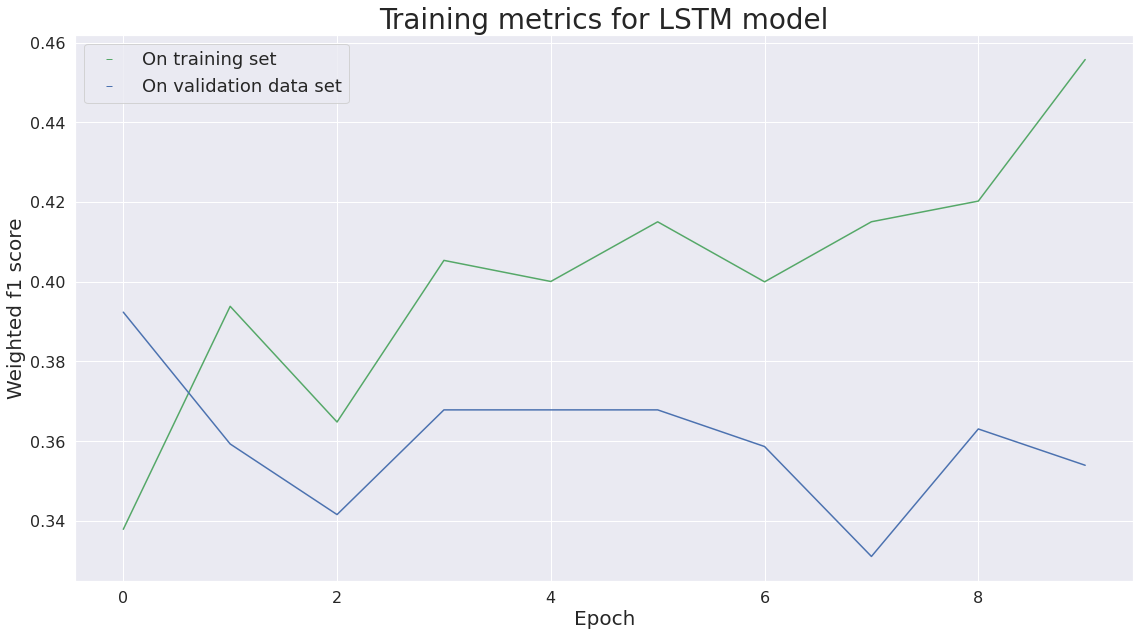

In [ ]:
# Set learning parameters
learning_rate = 0.001
epochs = 10

# Reconstruct motor activity sequences
reconstructed_train, reconstructed_val, reconstructed_test = reconstruct_data_sequences(
    [train_data, test_data, val_data], 48960
)

# Train the model
model, train_f1s, val_f1s = train(
    model,
    reconstructed_train,
    reconstructed_val,
    learning_rate=learning_rate,
    epochs=epochs,
    device=device,
)

# Plot training progress
plot_training_progress(train_f1s, val_f1s)

## BiLSTM with attention implementation for batched 24 hour sequences
This part of the notebook contains the BiLSTM with attention implementation for the complete sequence split data. In this implementation, each sequence is fed into a Linear Layer to encode it into a 1440 length sequence which is then passed through the BiLSTM layer to obtain the hidden vectors which are used in the remainder of the network.

### Load the data

In [ ]:
df = load_joint_dataset()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
data = convert_to_torch(
    df,
    slice_seq=False,
    preprocessing="False",
    k=10,
    train_perc=0.60,
    val_perc=0.20,
    random_seed=42,
    device=device,
)

train_data, val_data, test_data = data


     |█████▋                          | 10 kB 23.4 MB/s eta 0:00:01
     |███████████▎                    | 20 kB 25.5 MB/s eta 0:00:01
     |████████████████▉               | 30 kB 9.7 MB/s eta 0:00:01
     |██████████████████████▌         | 40 kB 4.5 MB/s eta 0:00:01
     |████████████████████████████    | 51 kB 5.1 MB/s eta 0:00:01
     |████████████████████████████████| 58 kB 2.7 MB/s 


2023-01-02 13:33:18.586 | INFO     | load_data:load_depresjon:36 - Loading depresjon
2023-01-02 13:33:21.945 | INFO     | load_data:load_psykose:54 - Loading psykose
2023-01-02 13:33:24.091 | INFO     | load_data:load_hyperaktiv:72 - Loading hyperaktiv
2023-01-02 13:34:42.864 | INFO     | load_data:convert_to_torch:222 - Converting to torch
2023-01-02 13:34:42.866 | INFO     | load_data:convert_to_torch:225 - Filtering out problematic dates
2023-01-02 13:35:05.983 | INFO     | load_data:train_val_test_split:188 - Split dataset into
   Training set:
      59.49% of total sequences
      Subjects: ADHD: 36, ADHD_Control: 36, DEPR_Control: 27, SZ: 16, DEPR: 18
   Validation set:
      20.20% of total sequences
      Subjects: ADHD: 9, ADHD_Control: 4, DEPR_Control: 5, DEPR: 5, SZ: 6
   Test set:
      20.31% of total sequences
      Subjects: DEPR_Control: 7, ADHD: 7, ADHD_Control: 6, SZ: 5, DEPR: 4



### Balance the train dataset

In [ ]:
balanced_train_data = balance_train(train_data)

### Ascertaining the number of data points in the longest present sequence

In [ ]:
longest_length = find_longest_sequence([train_data, test_data, val_data])
longest_length

64800

### Reconstruct the data sequences to ensure that they all have the same length

In [ ]:
reconstructed_train, reconstructed_val, reconstructed_test = reconstruct_data_sequences(
    [train_data, test_data, val_data], 64800
)
print(len(reconstructed_train))

104


In [ ]:
check_reconstructed_sequences(reconstructed_train, 64800)

True

### Initialising the BiLSTM with Attention Network

In [ ]:
class BiLSTMAttentionNetwork(nn.Module):
    def __init__(
        self,
        total_input_seq_len,
        encoder_output_len,
        seq_len,
        LSTM_hidden_size,
        n_layers,
        output_size,
        dropout=0.0,
    ):
        super(BiLSTMAttentionNetwork, self).__init__()
        self.encoder = nn.Linear(total_input_seq_len, 1440, n_layers)
        self.lstm = nn.LSTM(
            encoder_output_len, LSTM_hidden_size, n_layers, bidirectional=True
        )
        self.dense_1 = nn.Linear(LSTM_hidden_size * 2, LSTM_hidden_size * 2)
        self.dense_2 = nn.Linear(LSTM_hidden_size * 2, seq_len)
        self.dense_3 = nn.Linear(seq_len, seq_len // 2)
        self.dropout = nn.Dropout(p=dropout)
        self.dense_4 = nn.Linear(seq_len // 2, output_size)

    def forward(self, x):
        # Encode the data sequence
        encoded_input_sequence = self.encoder(torch.transpose(x, 0, 1))

        # Batch the generated encoded input sequence
        batched_seq = batch_data(encoded_input_sequence)

        # Send through LSTM and concatenate hidden states
        hidden_states, _ = self.lstm(batched_seq)
        hidden_states_cat = hidden_states.mean(axis=0)

        # Send through 1st dense layer
        output_dense_1 = self.dense_1(hidden_states_cat)
        attention_scores = F.softmax(output_dense_1, dim=0)

        # Compute the context vector
        context_vector = attention_scores * hidden_states_cat
        context_vector = torch.tanh(context_vector)

        # Compute prediction
        output_dense_2 = self.dense_2(context_vector)
        output_dense_2 = torch.tanh(output_dense_2)
        output_dense_3 = self.dense_3(output_dense_2)
        output_dense_3 = torch.tanh(output_dense_3)
        output_dense_3 = self.dropout(output_dense_3)
        output_dense_4 = self.dense_4(output_dense_3)

        return output_dense_4

### Define the variables of the BiLSTM Attention Network

In [ ]:
LSTM_hidden_size = 150
n_layers = 1
dropout = 0.1
seq_len = 50
output_size = 4
total_input_seq_len = longest_length
encoder_output_len = 360


# initializing the depression model
model = BiLSTMAttentionNetwork(
    total_input_seq_len,
    encoder_output_len,
    seq_len,
    LSTM_hidden_size,
    n_layers,
    output_size,
    dropout=0.0,
)
model.to(device)

BiLSTMAttentionNetwork(
  (encoder): Linear(in_features=64800, out_features=1440, bias=True)
  (lstm): LSTM(360, 150, bidirectional=True)
  (dense_1): Linear(in_features=300, out_features=300, bias=True)
  (dense_2): Linear(in_features=300, out_features=50, bias=True)
  (dense_3): Linear(in_features=50, out_features=25, bias=True)
  (dropout): Dropout(p=0.0, inplace=False)
  (dense_4): Linear(in_features=25, out_features=4, bias=True)
)

### Train the model


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 loss: 0.05764
actual class values:  [0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 3, 0, 1, 3, 0, 2, 1, 0, 2, 1, 1, 3, 1, 2, 1, 3, 1, 2, 3, 0, 1, 2, 1, 0, 2, 0, 2, 3, 1, 2, 1, 1, 1, 0, 1, 1, 2, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 3, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 2, 0, 1, 0, 0, 2, 3, 1, 1, 0, 0, 0, 0, 1, 2, 3, 1, 0, 0, 1, 0, 0, 0, 1, 3]
predicted class values:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
actual class values:  [1, 2, 0, 3, 3, 1, 2, 1, 1, 3, 2, 1, 1, 1, 2, 1, 1, 1, 1, 3, 2, 1, 0, 3, 1, 0, 1, 1, 1]



 10%|█         | 1/10 [00:10<01:37, 10.80s/it]

predicted class values:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Epoch: 2 loss: 0.05123
actual class values:  [0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 3, 0, 1, 3, 0, 2, 1, 0, 2, 1, 1, 3, 1, 2, 1, 3, 1, 2, 3, 0, 1, 2, 1, 0, 2, 0, 2, 3, 1, 2, 1, 1, 1, 0, 1, 1, 2, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 3, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 2, 0, 1, 0, 0, 2, 3, 1, 1, 0, 0, 0, 0, 1, 2, 3, 1, 0, 0, 1, 0, 0, 0, 1, 3]
predicted class values:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 3, 1, 1, 1, 1, 3, 1, 1, 3, 1, 3, 1, 1, 1, 3, 3, 1, 1, 3, 1, 1, 3, 1, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 3, 3, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3]
actual class values:  [1, 2, 0, 3, 3, 1, 2, 1, 1, 3, 2, 1, 1, 1, 2, 1, 1, 1, 1, 3, 2, 1, 0, 3, 1, 0, 1, 1, 1]



 20%|██        | 2/10 [00:20<01:23, 10.38s/it]

predicted class values:  [2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Epoch: 3 loss: 0.05266
actual class values:  [0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 3, 0, 1, 3, 0, 2, 1, 0, 2, 1, 1, 3, 1, 2, 1, 3, 1, 2, 3, 0, 1, 2, 1, 0, 2, 0, 2, 3, 1, 2, 1, 1, 1, 0, 1, 1, 2, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 3, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 2, 0, 1, 0, 0, 2, 3, 1, 1, 0, 0, 0, 0, 1, 2, 3, 1, 0, 0, 1, 0, 0, 0, 1, 3]
predicted class values:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 1, 2, 1, 3, 1, 1, 3, 1, 1, 1, 1, 3, 1, 1, 1, 3, 3, 1, 1, 1, 1, 1, 3, 1, 2, 3, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
actual class values:  [1, 2, 0, 3, 3, 1, 2, 1, 1, 3, 2, 1, 1, 1, 2, 1, 1, 1, 1, 3, 2, 1, 0, 3, 1, 0, 1, 1, 1]



 30%|███       | 3/10 [00:30<01:11, 10.21s/it]

predicted class values:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 2, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Epoch: 4 loss: 0.04681
actual class values:  [0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 3, 0, 1, 3, 0, 2, 1, 0, 2, 1, 1, 3, 1, 2, 1, 3, 1, 2, 3, 0, 1, 2, 1, 0, 2, 0, 2, 3, 1, 2, 1, 1, 1, 0, 1, 1, 2, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 3, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 2, 0, 1, 0, 0, 2, 3, 1, 1, 0, 0, 0, 0, 1, 2, 3, 1, 0, 0, 1, 0, 0, 0, 1, 3]
predicted class values:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 3, 1, 3, 1, 1, 3, 1, 1, 1, 1, 3, 1, 1, 1, 3, 3, 1, 1, 1, 1, 1, 3, 1, 3, 3, 1, 3, 1, 1, 1, 1, 1, 1, 3, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 1, 1, 1, 1, 1, 1, 1, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 3]
actual class values:  [1, 2, 0, 3, 3, 1, 2, 1, 1, 3, 2, 1, 1, 1, 2, 1, 1, 1, 1, 3, 2, 1, 0, 3, 1, 0, 1, 1, 1]



 40%|████      | 4/10 [00:40<01:00, 10.14s/it]

predicted class values:  [1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Epoch: 5 loss: 0.04398
actual class values:  [0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 3, 0, 1, 3, 0, 2, 1, 0, 2, 1, 1, 3, 1, 2, 1, 3, 1, 2, 3, 0, 1, 2, 1, 0, 2, 0, 2, 3, 1, 2, 1, 1, 1, 0, 1, 1, 2, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 3, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 2, 0, 1, 0, 0, 2, 3, 1, 1, 0, 0, 0, 0, 1, 2, 3, 1, 0, 0, 1, 0, 0, 0, 1, 3]
predicted class values:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 2, 2, 1, 1, 2, 1, 1, 2, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2]
actual class values:  [1, 2, 0, 3, 3, 1, 2, 1, 1, 3, 2, 1, 1, 1, 2, 1, 1, 1, 1, 3, 2, 1, 0, 3, 1, 0, 1, 1, 1]



 50%|█████     | 5/10 [00:50<00:50, 10.08s/it]

predicted class values:  [1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Epoch: 6 loss: 0.04194
actual class values:  [0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 3, 0, 1, 3, 0, 2, 1, 0, 2, 1, 1, 3, 1, 2, 1, 3, 1, 2, 3, 0, 1, 2, 1, 0, 2, 0, 2, 3, 1, 2, 1, 1, 1, 0, 1, 1, 2, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 3, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 2, 0, 1, 0, 0, 2, 3, 1, 1, 0, 0, 0, 0, 1, 2, 3, 1, 0, 0, 1, 0, 0, 0, 1, 3]
predicted class values:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 2, 2, 1, 1, 2, 1, 1, 2, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2]
actual class values:  [1, 2, 0, 3, 3, 1, 2, 1, 1, 3, 2, 1, 1, 1, 2, 1, 1, 1, 1, 3, 2, 1, 0, 3, 1, 0, 1, 1, 1]



 60%|██████    | 6/10 [01:00<00:40, 10.03s/it]

predicted class values:  [2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Epoch: 7 loss: 0.03900
actual class values:  [0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 3, 0, 1, 3, 0, 2, 1, 0, 2, 1, 1, 3, 1, 2, 1, 3, 1, 2, 3, 0, 1, 2, 1, 0, 2, 0, 2, 3, 1, 2, 1, 1, 1, 0, 1, 1, 2, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 3, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 2, 0, 1, 0, 0, 2, 3, 1, 1, 0, 0, 0, 0, 1, 2, 3, 1, 0, 0, 1, 0, 0, 0, 1, 3]
predicted class values:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2]
actual class values:  [1, 2, 0, 3, 3, 1, 2, 1, 1, 3, 2, 1, 1, 1, 2, 1, 1, 1, 1, 3, 2, 1, 0, 3, 1, 0, 1, 1, 1]



 70%|███████   | 7/10 [01:11<00:31, 10.37s/it]

predicted class values:  [2, 1, 1, 2, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Epoch: 8 loss: 0.03827
actual class values:  [0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 3, 0, 1, 3, 0, 2, 1, 0, 2, 1, 1, 3, 1, 2, 1, 3, 1, 2, 3, 0, 1, 2, 1, 0, 2, 0, 2, 3, 1, 2, 1, 1, 1, 0, 1, 1, 2, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 3, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 2, 0, 1, 0, 0, 2, 3, 1, 1, 0, 0, 0, 0, 1, 2, 3, 1, 0, 0, 1, 0, 0, 0, 1, 3]
predicted class values:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 2, 2, 1, 1, 1, 1, 1, 2, 1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2]
actual class values:  [1, 2, 0, 3, 3, 1, 2, 1, 1, 3, 2, 1, 1, 1, 2, 1, 1, 1, 1, 3, 2, 1, 0, 3, 1, 0, 1, 1, 1]



 80%|████████  | 8/10 [01:22<00:20, 10.29s/it]

predicted class values:  [2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]
Epoch: 9 loss: 0.03881
actual class values:  [0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 3, 0, 1, 3, 0, 2, 1, 0, 2, 1, 1, 3, 1, 2, 1, 3, 1, 2, 3, 0, 1, 2, 1, 0, 2, 0, 2, 3, 1, 2, 1, 1, 1, 0, 1, 1, 2, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 3, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 2, 0, 1, 0, 0, 2, 3, 1, 1, 0, 0, 0, 0, 1, 2, 3, 1, 0, 0, 1, 0, 0, 0, 1, 3]
predicted class values:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 2, 1, 2, 1, 0, 1, 2, 2, 1, 1, 0, 1, 1, 2, 1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2]
actual class values:  [1, 2, 0, 3, 3, 1, 2, 1, 1, 3, 2, 1, 1, 1, 2, 1, 1, 1, 1, 3, 2, 1, 0, 3, 1, 0, 1, 1, 1]



 90%|█████████ | 9/10 [01:32<00:10, 10.22s/it]

predicted class values:  [2, 1, 1, 2, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0]
Epoch: 10 loss: 0.03710
actual class values:  [0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 3, 0, 1, 3, 0, 2, 1, 0, 2, 1, 1, 3, 1, 2, 1, 3, 1, 2, 3, 0, 1, 2, 1, 0, 2, 0, 2, 3, 1, 2, 1, 1, 1, 0, 1, 1, 2, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 3, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 2, 0, 1, 0, 0, 2, 3, 1, 1, 0, 0, 0, 0, 1, 2, 3, 1, 0, 0, 1, 0, 0, 0, 1, 3]
predicted class values:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 0, 1, 2, 1, 0, 1, 2, 2, 1, 1, 0, 1, 1, 2, 1, 2, 2, 1, 0, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 0, 1, 1, 2]
actual class values:  [1, 2, 0, 3, 3, 1, 2, 1, 1, 3, 2, 1, 1, 1, 2, 1, 1, 1, 1, 3, 2, 1, 0, 3, 1, 0, 1, 1, 1]


100%|██████████| 10/10 [01:42<00:00, 10.23s/it]

predicted class values:  [2, 1, 1, 2, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 2, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0]


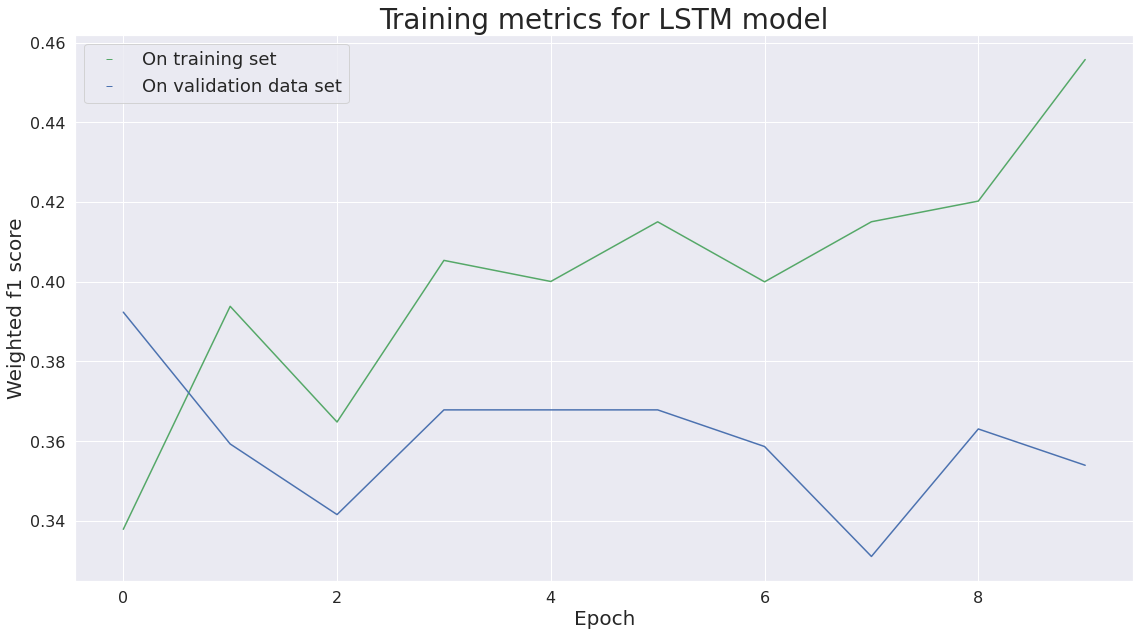

In [ ]:
# Set learning parameters
learning_rate = 0.001
epochs = 10

# Reconstruct motor activity sequences
reconstructed_train, reconstructed_val, reconstructed_test = reconstruct_data_sequences(
    [train_data, test_data, val_data], 48960
)

# Train the model
model, train_f1s, val_f1s = train(
    model,
    reconstructed_train,
    reconstructed_val,
    learning_rate=learning_rate,
    epochs=epochs,
    device=device,
)

# Plot training progress
plot_training_progress(train_f1s, val_f1s)